In [2]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt


# origin is center of the court
three_d_keypoints = [
    (-10.97 / 2, 0, 23.77 / 2),
    (10.97 / 2, 0, 23.77 / 2),
    (-10.97 / 2, 0, -23.77 / 2),
    (10.97 / 2, 0, -23.77 / 2),
    (-8.23 / 2, 0, 23.77 / 2),
    (-8.23 / 2, 0, -23.77 / 2),
    (8.23 / 2, 0, 23.77 / 2),
    (8.23 / 2, 0, -23.77 / 2),
    (-8.23 / 2, 0, 6.4),
    (8.23 / 2, 0, 6.4),
    (-8.23 / 2, 0, -6.4),
    (8.23 / 2, 0, -6.4),
    (0, 0, 6.4),
    (0, 0, -6.4),
]


class ConvBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, pad=1, stride=1, bias=True
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride=stride,
                padding=pad,
                bias=bias,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.block(x)


class BallTrackerNet(nn.Module):
    def __init__(self, out_channels=14):
        super().__init__()
        self.out_channels = out_channels

        self.conv1 = ConvBlock(in_channels=3, out_channels=64)
        self.conv2 = ConvBlock(in_channels=64, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = ConvBlock(in_channels=64, out_channels=128)
        self.conv4 = ConvBlock(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = ConvBlock(in_channels=128, out_channels=256)
        self.conv6 = ConvBlock(in_channels=256, out_channels=256)
        self.conv7 = ConvBlock(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv8 = ConvBlock(in_channels=256, out_channels=512)
        self.conv9 = ConvBlock(in_channels=512, out_channels=512)
        self.conv10 = ConvBlock(in_channels=512, out_channels=512)
        self.ups1 = nn.Upsample(scale_factor=2)
        self.conv11 = ConvBlock(in_channels=512, out_channels=256)
        self.conv12 = ConvBlock(in_channels=256, out_channels=256)
        self.conv13 = ConvBlock(in_channels=256, out_channels=256)
        self.ups2 = nn.Upsample(scale_factor=2)
        self.conv14 = ConvBlock(in_channels=256, out_channels=128)
        self.conv15 = ConvBlock(in_channels=128, out_channels=128)
        self.ups3 = nn.Upsample(scale_factor=2)
        self.conv16 = ConvBlock(in_channels=128, out_channels=64)
        self.conv17 = ConvBlock(in_channels=64, out_channels=64)
        self.conv18 = ConvBlock(in_channels=64, out_channels=self.out_channels)

        self._init_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.ups1(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.ups2(x)
        x = self.conv14(x)
        x = self.conv15(x)
        x = self.ups3(x)
        x = self.conv16(x)
        x = self.conv17(x)
        x = self.conv18(x)
        return F.sigmoid(x)

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.uniform_(module.weight, -0.05, 0.05)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)


def postprocess(heatmap, scale=2, low_thresh=250, min_radius=10, max_radius=30):
    x_pred, y_pred = None, None
    ret, heatmap = cv2.threshold(heatmap, low_thresh, 255, cv2.THRESH_BINARY)
    circles = cv2.HoughCircles(
        heatmap,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=20,
        param1=50,
        param2=5,
        minRadius=10,
    )
    if circles is not None:
        x_pred = circles[0][0][0] * scale
        y_pred = circles[0][0][1] * scale
    return x_pred, y_pred


def get_keypoints(preds: torch.Tensor):
    points = []
    for kps_num in range(14):
        heatmap = (preds[kps_num] * 255).astype(np.uint8)
        x_pred, y_pred = postprocess(heatmap, scale=1, low_thresh=170, max_radius=25)
        points.append((x_pred, y_pred))
    return points


class tracknet_transform(torch.nn.Module):
    def __init__(
        self,
        size: tuple,
    ) -> None:
        self.img_size = size

    def __call__(self, img_path: str) -> torch.Tensor:
        image = Image.open(img_path).convert("RGB").resize(self.img_size)
        image = torch.from_numpy(np.array(image) / 255.0).float()
        image = image.permute(2, 0, 1)
        return image


def refine_keypoints(keypoints: list, image: np.ndarray, window_size=20):
    """
    Refines keypoints by finding the centroid of line intersections.
    Robust to thick/pixelated lines.

    Args:
        keypoints: List of (x, y) tuples from initial detection
        image: Original image as numpy array (H, W, 3)
        window_size: Size of the window to search around each keypoint

    Returns:
        List of refined (x, y) tuples
    """
    refined_keypoints = []

    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    h, w = gray.shape

    for x_pred, y_pred in keypoints[:]:
        if x_pred is None or y_pred is None:
            refined_keypoints.append((None, None))
            continue

        x_pred, y_pred = int(x_pred), int(y_pred)

        x_min = max(0, x_pred - window_size)
        x_max = min(w, x_pred + window_size)
        y_min = max(0, y_pred - window_size)
        y_max = min(h, y_pred + window_size)

        window = gray[y_min:y_max, x_min:x_max]

        if window.size == 0:
            refined_keypoints.append((x_pred, y_pred))
            continue

        _, binary = cv2.threshold(window * 255, 200, 255, cv2.THRESH_BINARY)
        skeleton = binary

        corners = cv2.goodFeaturesToTrack(
            skeleton, maxCorners=5, qualityLevel=0.01, minDistance=5, blockSize=3
        )

        if corners is not None and len(corners) > 0:
            center_x, center_y = window.shape[1] // 2, window.shape[0] // 2
            corners = corners.reshape(-1, 2)
            closest = min(
                corners, key=lambda p: (p[0] - center_x) ** 2 + (p[1] - center_y) ** 2
            )
            refined_x = closest[0] + x_min
            refined_y = closest[1] + y_min
            refined_keypoints.append((refined_x, refined_y))
        else:
            center_x, center_y = window.shape[1] // 2, window.shape[0] // 2
            y_coords, x_coords = np.where(binary > 0)

            if len(x_coords) > 0:
                # Calculate weights based on distance to center
                distances = np.sqrt(
                    (x_coords - center_x) ** 2 + (y_coords - center_y) ** 2
                )
                weights = np.exp(-distances / 10)  # Gaussian weighting

                # Weighted centroid
                centroid_x = np.average(x_coords, weights=weights)
                centroid_y = np.average(y_coords, weights=weights)

                refined_x = centroid_x + x_min
                refined_y = centroid_y + y_min
                refined_keypoints.append((refined_x, refined_y))
            else:
                refined_keypoints.append((x_pred, y_pred))
    return refined_keypoints


def estimate_focal_range(image_width, image_height):
    """Conservative search range"""

    # Assume FOV between 30° and 90°
    min_f = image_width / (2 * np.tan(np.radians(90) / 2))  # Wide
    max_f = image_width / (2 * np.tan(np.radians(30) / 2))  # Narrow

    # Add 20% margin
    min_f *= 0.8
    max_f *= 1.2

    return min_f, max_f


def solve_pnp_with_focal_search(
    object_points, image_points, focal_range=(500, 2000), principal_point=None
):
    """
    object_points: Nx3 array of 3D points
    image_points: Nx2 array of 2D image points
    focal_range: (min_f, max_f) to search
    """
    if principal_point is None:
        principal_point = (image_points[:, 0].mean(), image_points[:, 1].mean())

    best_f = None
    best_error = float("inf")
    best_pose = None

    # Try different focal lengths
    for f in np.linspace(focal_range[0], focal_range[1], 50):
        camera_matrix = np.array(
            [[f, 0, principal_point[0]], [0, f, principal_point[1]], [0, 0, 1]],
            dtype=np.float32,
        )

        # Solve PnP - this returns multiple solutions for coplanar points
        success, rvec, tvec = cv2.solvePnP(
            object_points,
            image_points,
            camera_matrix,
            None,  # no distortion
            flags=cv2.SOLVEPNP_IPPE,  # Good for planar points
        )

        if success:
            # Compute reprojection error
            projected, _ = cv2.projectPoints(
                object_points, rvec, tvec, camera_matrix, None
            )
            error = np.mean(np.linalg.norm(projected.squeeze() - image_points, axis=1))

            if error < best_error:
                best_error = error
                best_f = f
                best_pose = (rvec, tvec)

    return best_f, best_pose, best_error

def get_points(keypoints: list):
    points_2d = []
    points_3d = []
    for idx, keypoint in enumerate(keypoints):
        if keypoint[0] is not None and keypoint[1] is not None:
            points_2d.append(keypoint)
            points_3d.append(three_d_keypoints[idx])
    return np.array(points_2d), np.array(points_3d)

def plot_keypoints(keypoints: list, image: np.ndarray):
    for idx, keypoint in enumerate(keypoints):
        if keypoint[0] is not None and keypoint[1] is not None:
            # plot text
            cv2.putText(image, str(idx), (int(keypoint[0]), int(keypoint[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
            cv2.circle(image, (int(keypoint[0]), int(keypoint[1])), 5, (0, 0, 255), -1)
    return image

def solve_planar_pnp(object_points, image_points, camera_matrix):
    """Handles the planar ambiguity explicitly"""
    
    # IPPE returns both possible solutions
    success, rvecs, tvecs, reprojErrors = cv2.solvePnPGeneric(
        object_points,
        image_points,
        camera_matrix,
        None,
        flags=cv2.SOLVEPNP_IPPE
    )
    
    # You'll get 2 solutions - pick based on physical constraints
    # e.g., camera should be in front of points, not behind
    for i, (rvec, tvec) in enumerate(zip(rvecs, tvecs)):
        print(f"Solution {i}:")
        print(f"  Rotation: {rvec.ravel()}")
        print(f"  Translation: {tvec.ravel()}")
        print(f"  Reprojection error: {reprojErrors[i]}")
    
    return rvecs, tvecs, reprojErrors

def get_camera_pose_in_world(rvec, tvec):
    """Get camera position in world coordinates"""
    R, _ = cv2.Rodrigues(rvec)  # Convert axis-angle to rotation matrix
    
    # Camera position in world frame
    camera_position = -R.T @ tvec
    
    # Camera orientation in world frame
    R_world = R.T  # Rotation from camera to world
    
    return camera_position, R_world

def rvec_tvec_to_extrinsic(rvec, tvec):
    R, _ = cv2.Rodrigues(rvec)
    extrinsic_3x4 = np.hstack([R, tvec.reshape(3, 1)])
    
    return extrinsic_3x4

def select_valid_solution(rvecs, tvecs, reprojErrors):
    """Select the solution where camera is above the court (positive Y)"""
    
    for i, (rvec, tvec) in enumerate(zip(rvecs, tvecs)):
        camera_pos, _ = get_camera_pose_in_world(rvec, tvec)
        
        # For tennis court: camera should be above ground (Y > 0)
        # and in front of court (reasonable Z value)
        if camera_pos[2] < 0:  # camera is behind the court
            print(f"Selected solution {i}: Camera at {camera_pos.ravel()}")
            return rvec, tvec, reprojErrors[i]
    
    # Fallback to lowest reprojection error
    best_idx = np.argmin(reprojErrors)
    return rvecs[best_idx], tvecs[best_idx], reprojErrors[best_idx]

def read_txt_file(file_path: str):
    with open(file_path, "r") as f:
        return f.readlines()
    
def get_2d_and_3d_keypoints(file_path: str):
    keypoints = read_txt_file(file_path)
    keypoints = [tuple(map(float, line.split())) for line in keypoints]
    points_3d = []
    for keypoint in keypoints:
        points_3d.append(three_d_keypoints[int(keypoint[0])])
    points_2d = []
    for keypoint in keypoints:
        points_2d.append((keypoint[1], keypoint[2]))
    return np.array(points_2d), np.array(points_3d)


Solution 0:
  Rotation: [0.18745149 0.13036535 0.00498236]
  Translation: [ 0.72575775 -1.18454624 15.86802932]
  Reprojection error: [131.14654728]
Solution 1:
  Rotation: [-3.13687757 -0.00682112 -0.00578643]
  Translation: [ 0.54392243 -0.81805349 18.74723723]
  Reprojection error: [1157.70054108]
Selected solution 0: Camera at [  1.34398044  -1.79526099 -15.77006605]


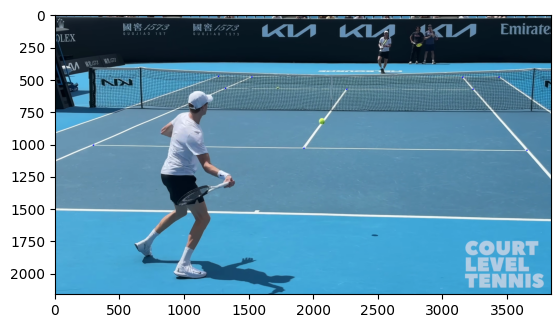

In [27]:
keypoints_path = "/Users/derek/Desktop/sports_3d/data/sinner_ruud_keypoints/frame_004200_t70.000s_keypoints.txt"
image = cv2.imread("/Users/derek/Desktop/sports_3d/data/sinner_ruud_Frames/frame_004200_t70.000s.png")
keypoints_2d, keypoints_3d = get_2d_and_3d_keypoints(keypoints_path)
plt.imshow(plot_keypoints(keypoints_2d, cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
min_f, max_f = estimate_focal_range(image.shape[0], image.shape[1])
best_f, best_pose, best_error = solve_pnp_with_focal_search(
    keypoints_3d, keypoints_2d, focal_range=(min_f, max_f), principal_point=(image.shape[1] / 2, image.shape[0] / 2)
)

camera_matrix = np.array(
    [[best_f, 0, image.shape[1] / 2], [0, best_f, image.shape[0] / 2], [0, 0, 1]],
    dtype=np.float32,
)
rvecs, tvecs, errors = solve_planar_pnp(keypoints_3d, keypoints_2d, camera_matrix)
rvec, tvec, error = select_valid_solution(rvecs, tvecs, errors)
camera_pos, R_world = get_camera_pose_in_world(rvec, tvec)
extrinsic_matrix = rvec_tvec_to_extrinsic(rvec, tvec)

['0', '0.655729', '0.190046', '0.004687', '0.008796']
[(2504, 396), (2531, 424)]
result None
refining_edges


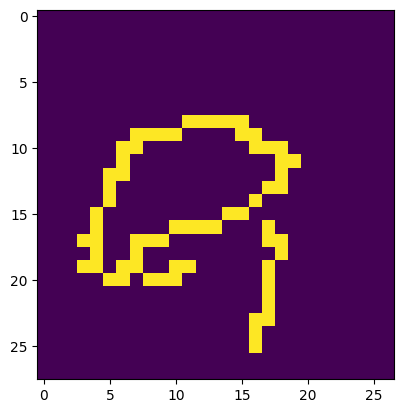

refined_bbox [(2506, 403), (2524, 421)]


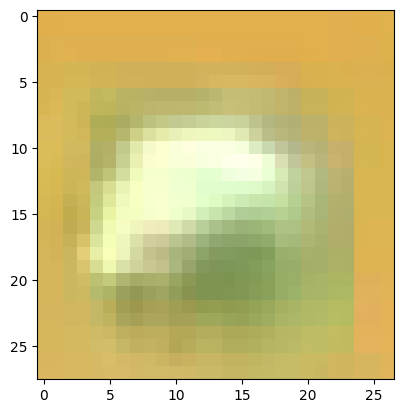

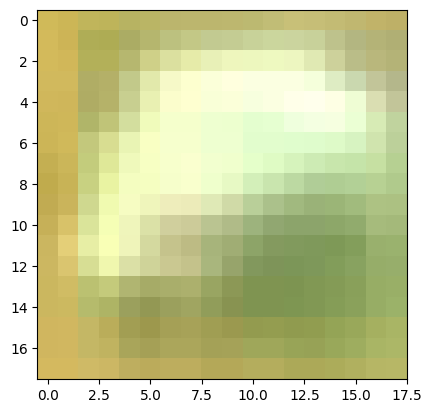

In [23]:
from typing import Optional

import cv2
import numpy as np


def _detect_ball_hough(roi: np.ndarray, params: dict) -> Optional[tuple]:
    """
    Detect tennis ball using circular Hough transform.

    Args:
        roi: Region of interest in BGR format
        params: Detection parameters (minRadius, maxRadius)

    Returns:
        (center_x, center_y, radius) in ROI coordinates, or None if detection fails
    """
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Bilateral filter preserves ball edges while smoothing text
    blurred = cv2.bilateralFilter(enhanced, 9, 75, 75)

    roi_h, roi_w = roi.shape[:2]
    min_dist = max(roi_w, roi_h) // 2

    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=min_dist,
        param1=50,
        param2=25,  # Slightly higher threshold for stronger circle evidence
        minRadius=params['minRadius'],
        maxRadius=params['maxRadius']
    )

    if circles is not None and len(circles[0]) > 0:
        roi_center = (roi_w / 2, roi_h / 2)
        best_circle = None
        min_dist_to_center = float('inf')

        for circle in circles[0]:
            x, y, r = circle
            dist = np.sqrt((x - roi_center[0])**2 + (y - roi_center[1])**2)
            if dist < min_dist_to_center:
                min_dist_to_center = dist
                best_circle = (float(x), float(y), float(r))

        return best_circle

    return None


def _detect_ball_color(roi: np.ndarray, params: dict) -> Optional[tuple]:
    """
    Detect tennis ball using HSV color segmentation.

    Args:
        roi: Region of interest in BGR format
        params: Detection parameters (minRadius, maxRadius)

    Returns:
        (center_x, center_y, radius) in ROI coordinates, or None if detection fails
    """
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Hue 25-85 covers yellow-green range typical of tennis balls
    lower_green_yellow = np.array([25, 50, 50])
    upper_green_yellow = np.array([85, 255, 255])

    mask = cv2.inRange(hsv, lower_green_yellow, upper_green_yellow)

    # Fill holes from black text with morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    roi_h, roi_w = roi.shape[:2]
    roi_center = (roi_w / 2, roi_h / 2)
    best_contour = None
    best_score = -1

    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 10:
            continue

        (x, y), radius = cv2.minEnclosingCircle(contour)

        if not (params['minRadius'] <= radius <= params['maxRadius']):
            continue

        # Use convex hull for circularity to handle irregular contours from text
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        hull_perimeter = cv2.arcLength(hull, True)
        
        if hull_perimeter == 0:
            continue
        circularity = 4 * np.pi * hull_area / (hull_perimeter ** 2)

        center_dist = np.sqrt((x - roi_center[0])**2 + (y - roi_center[1])**2)
        score = circularity * area / (center_dist + 1)

        if score > best_score:
            best_score = score
            best_contour = (float(x), float(y), float(radius))

    return best_contour if best_score > 0 else None

def refine_with_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    
    plt.imshow(edges)
    plt.show()
    
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Combine all edge points
        all_points = np.vstack(contours)
        (x, y), radius = cv2.minEnclosingCircle(all_points)
        x, y, radius = int(x), int(y), int(radius)
        return (x-radius, y-radius, 2*radius, 2*radius)
    
    return None


def refined_tennis_ball_box(
    box: list[tuple[int, int]],
    image: np.ndarray,
) -> list[tuple[int, int]]:
    """
    Refines a bounding box to tightly fit a tennis ball using multi-method detection.

    Args:
        box: Bounding box [(x1, y1), (x2, y2)] in pixel coordinates
        image: Image array in BGR format (OpenCV standard)

    Returns:
        Refined box [(x1, y1), (x2, y2)] or original box if all refinement methods fail
    """
    (x1, y1), (x2, y2) = box
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    h, w = image.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)

    if x2 <= x1 or y2 <= y1:
        return box

    roi = image[y1:y2, x1:x2].copy()
    roi_h, roi_w = roi.shape[:2]

    min_dim = min(roi_w, roi_h)
    min_radius = int(min_dim * 0.4)
    max_radius = int(min_dim * 1.2)

    params = {
        'minRadius': min_radius,
        'maxRadius': max_radius
    }

    result = _detect_ball_hough(roi, params)
    print("result", result)

    if result is None:
        result = _detect_ball_color(roi, params)

    if result is None:
        print("refining_edges")
        edge_box = refine_with_edges(roi)
        if edge_box is not None:
            edge_x1, edge_y1, edge_w, edge_h = edge_box
            refined_x1 = int(max(0, x1 + edge_x1))
            refined_y1 = int(max(0, y1 + edge_y1))
            refined_x2 = int(min(w, x1 + edge_x1 + edge_w))
            refined_y2 = int(min(h, y1 + edge_y1 + edge_h))

            original_area = (x2 - x1) * (y2 - y1)
            refined_area = (refined_x2 - refined_x1) * (refined_y2 - refined_y1)

            if refined_area <= original_area * 1.05 and refined_area >= original_area * 0.3:
                return [(refined_x1, refined_y1), (refined_x2, refined_y2)]

        return box

    cx_roi, cy_roi, radius = result
    cx_img = x1 + cx_roi
    cy_img = y1 + cy_roi

    margin = 1.03
    refined_radius = radius * margin

    refined_x1 = int(max(0, cx_img - refined_radius))
    refined_y1 = int(max(0, cy_img - refined_radius))
    refined_x2 = int(min(w, cx_img + refined_radius))
    refined_y2 = int(min(h, cy_img + refined_radius))

    original_area = (x2 - x1) * (y2 - y1)
    refined_area = (refined_x2 - refined_x1) * (refined_y2 - refined_y1)

    if refined_area > original_area * 1.05:
        return box

    if refined_area < original_area * 0.3:
        return box

    return [(refined_x1, refined_y1), (refined_x2, refined_y2)]

bbox = read_txt_file("/Users/derek/Desktop/sports_3d/data/sinner_ruud_bbox/frame_004249_t70.817s_bbox.txt")
image = cv2.imread("/Users/derek/Desktop/sports_3d/data/sinner_ruud_Frames/frame_004249_t70.817s.png")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(bbox[0].split())
bbox = [list(map(float, line.split())) for line in bbox]
image_height, image_width, _ = image.shape
bbox = bbox[0][1:]
bbox[2] = bbox[2] * 1.5
bbox[3] = bbox[3] * 1.5
x = int(bbox[0] * image_width - bbox[2] * (image_width / 2))
y = int(bbox[1] * image_height - bbox[3] * image_height / 2)
x2 = int(bbox[0] * image_width + bbox[2] * image_width / 2)
y2 = int(bbox[1] * image_height + bbox[3] * image_height / 2)
bbox = [(x, y), (x2, y2)]
extracted_image = image[y:y2, x:x2]

print(bbox)
refined_bbox = refined_tennis_ball_box(bbox, image)
refined_extracted = image[refined_bbox[0][1]:refined_bbox[1][1], refined_bbox[0][0]:refined_bbox[1][0]]
print("refined_bbox", refined_bbox)

plt.imshow(extracted_image)
plt.show()
plt.imshow(refined_extracted)
plt.show()
